<a href="https://colab.research.google.com/github/vivekrathi14/CSC522-BERTQnA/blob/main/BERTforQnA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [ ]:
!pip install transformers
!pip install wandb

     |████████████████████████████████| 2.1MB 19.0MB/s 
     |████████████████████████████████| 3.3MB 47.9MB/s 
     |████████████████████████████████| 901kB 55.6MB/s 
     |████████████████████████████████| 2.1MB 19.6MB/s 
     |████████████████████████████████| 133kB 59.9MB/s 
     |████████████████████████████████| 163kB 52.3MB/s 
     |████████████████████████████████| 102kB 14.1MB/s 
     |████████████████████████████████| 71kB 11.5MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=2c4c644ad46bb1918ddbe6bfab178b1d852094d5bf309c4e45f69f92fcf6b123
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=c610c99ede137397e6a278c7455ba32f95774e8f73f675d360dc6d8e80974365
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
DATA_PATH = "/content/drive/MyDrive/ALDA_project/google-quest-challenge/train.csv"
data = pd.read_csv(DATA_PATH)

In [ ]:
data.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,photo.stackexchange.com,1.000000,0.333333,0.000000,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,rpg.stackexchange.com,1.000000,1.000000,0.000000,0.5,1.0,1.0,0.444444,0.444444,0.666667,0.0,0.000000,0.666667,0.666667,0.0,0.333333,0.0,0.0,0.000000,0.333333,0.0,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,electronics.stackexchange.com,0.888889,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.444444,0.333333,0.0,0.333333,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.333333,0.333333,0.0,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,judaism.stackexchange.com,0.888889,0.666667,0.666667,1.0,1.0,1.0,0.444444,0.444444,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,graphicdesign.stackexchange.com,1.000000,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.666667,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,1.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6079 entries, 0 to 6078
Data columns (total 41 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   qa_id                                  6079 non-null   int64  
 1   question_title                         6079 non-null   object 
 2   question_body                          6079 non-null   object 
 3   question_user_name                     6079 non-null   object 
 4   question_user_page                     6079 non-null   object 
 5   answer                                 6079 non-null   object 
 6   answer_user_name                       6079 non-null   object 
 7   answer_user_page                       6079 non-null   object 
 8   url                                    6079 non-null   object 
 9   category                               6079 non-null   object 
 10  host                                   6079 non-null   object 
 11  ques

In [ ]:
prediction_columns = list(data.columns)[11:]
input_columns = list(data.columns)[:11]
print(prediction_columns)
print(input_columns)

['question_asker_intent_understanding', 'question_body_critical', 'question_conversational', 'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer', 'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice', 'question_type_compare', 'question_type_consequence', 'question_type_definition', 'question_type_entity', 'question_type_instructions', 'question_type_procedure', 'question_type_reason_explanation', 'question_type_spelling', 'question_well_written', 'answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance', 'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 'answer_type_reason_explanation', 'answer_well_written']
['qa_id', 'question_title', 'question_body', 'question_user_name', 'question_user_page', 'answer', 'answer_user_name', 'answer_user_page', 'url', 'category', 

In [ ]:
X, y = data[input_columns],data[prediction_columns]

####Import and load BERT model as model

In [ ]:
from transformers import BertTokenizer, BertModel

In [ ]:
# Store the model we want to use
MODEL_NAME = "bert-base-uncased"

# We need to create the model and tokenizer
model = BertModel.from_pretrained(MODEL_NAME)
model.to('cuda')
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

####BERT Related variables and methods

In [ ]:
BERT_columns = ['question_title', 'question_body', 'answer']
BERT_max_sentence_size = 512
BERT_embedding_size = 768

In [ ]:
# Methods for getting BERT based features

def extract_BERT_last_hidden_CLS(outputs):
  # extracts and returns vector of shape (768,)
    return outputs[0][0][0].cpu().detach().numpy()

def BERT_tokens(string):
    # returns BERT tokens in CUDA memory
    # tokens is of type pytorch tensor
    tokens = tokenizer(string, return_tensors="pt")
    # put every key's value to cuda
    for k in tokens.keys():
        tokens[k] = tokens[k].to('cuda')
    return tokens


def get_BERT_features(string):
    # # returns BERT features that can be used as input to ML model
    inputs = BERT_tokens(string)
    # get BERT output
    outputs = model(**inputs)
    # get the vector of shape (768,)
    return extract_BERT_last_hidden_CLS(outputs)

# returns pandas dataframe with BERT features for all input samples
# here we get |768|768|...|768| type of column values based on input features used
def BERT_features_df(X):
    # import tqdm for time based for loop
    from tqdm import tqdm
    # empty list
    _BERT_features = []
    # we have BERT_columns = ['question_title', 'question_body', 'answer'] i.e. input features space
    for col in BERT_columns:
        features = []
        for idx in tqdm(range(len(X[col]))):
            # get the text in row variable
            row = X[col][idx]
            # we can get BERT features only for max BERT sentence_size i.e 512
            # anything after length of 512 will be truncated
            features.append(get_BERT_features(row[:BERT_max_sentence_size]))
            # features = [f1,f2,...,fn] where each fi is list or array of size 768
        _BERT_features.append(pd.DataFrame(features))
        # _BERT_features is list with [d1,d2,..,dn] where di is dataframe
    BERT_features = pd.concat(_BERT_features, axis=1)
    # BERT_features is dataframe that concats _BERT_features horizontally,
    # [[1....768],[1....768],....,[1.....768]] where [1.....768] is feature space for chosen input attribute/features
    return BERT_features


def BERT_features_df_PCA(X, trained_pca=None):
    # import tqdm for time based for loop
    from tqdm import tqdm
    # empty list
    _BERT_features = []
    # we have BERT_columns = ['question_title', 'question_body', 'answer'] i.e. input features space
    for col in BERT_columns:
        features = []
        for idx in tqdm(range(len(X[col]))):
            # get the text in row variable
            row = X[col][idx]
            # we can get BERT features only for max BERT sentence_size i.e 512
            # anything after length of 512 will be truncated
            features.append(get_BERT_features(row[:BERT_max_sentence_size]))
            # features = [f1,f2,...,fn] where each fi is list or array of size 768
        _BERT_features.append(pd.DataFrame(features))
        # _BERT_features is list with [d1,d2,..,dn] where di is dataframe
    BERT_features = pd.concat(_BERT_features, axis=1)
    # BERT_features is dataframe that concats _BERT_features horizontally,
    # [[1....768],[1....768],....,[1.....768]] where [1.....768] is feature space for chosen input attribute/features

    from sklearn.decomposition import PCA

    _reduced_BERT_features = []
    # define pca with 70 components
    pca = PCA(n_components=70) ## note n_components can also be hyperparameter

    for i, col in enumerate(BERT_columns):
        # we get pca_input_features [[1....768],[1......768],....,[1......768]]
        # where we pass each [1.....768] values individually
        pca_input_features = BERT_features.iloc[:, i*BERT_embedding_size:(i+1)*BERT_embedding_size]
        if not trained_pca:
            trained_pca = pca.fit(pca_input_features)
        # we transform input to get features = pca_components i.e. here 70
        features = trained_pca.transform(pca_input_features)
        # features size is (samples,70*no. of chosen attributes) against (samples,768*no. of chosen attributes)
        # here no. of chosen attributes is 3 due to ['question_title', 'question_body', 'answer']
        _reduced_BERT_features.append(pd.DataFrame(features))

    reduced_BERT_features = pd.concat(_reduced_BERT_features, axis=1)
    # reduced_BERT_features is dataframe that concats _reduced_BERT_features horizontally,
    # [[1....70],[1....70],....,[1.....70]] where [1.....70] is feature space for chosen input attribute/features
    return reduced_BERT_features, trained_pca


# creates one hot encoding for "Host" & "Category" attributes
# returns dataframe with one hot encoding as well as additonal length of each sample for
# used ['question_title', 'question_body', 'answer'] columns along with non embedding (one hot coded)
# and non BERT features dataframe


def non_BERT_features_df(X):
    # preprocessing has OneHotEncoder API
    from sklearn import preprocessing
    # create encoder
    host_category_encoder = preprocessing.OneHotEncoder(drop='first').fit(X[['host', 'category']])
    # get encoding
    host_category_encoding = host_category_encoder.transform(X[['host', 'category']]).toarray()

    # assertion to check the implementation
    assert host_category_encoding.shape[1] == len(X['host'].unique()) + len(X['category'].unique()) - 2
    assert host_category_encoding.shape[0] == len(X['host'])

    X_non_BERT_features = pd.concat([pd.DataFrame(host_category_encoding), X['question_title'].map(len), X['question_body'].map(len), X['answer'].map(len)], axis=1)

    non_embedding_non_BERT_features = X_non_BERT_features.iloc[:,-3:]

    return X_non_BERT_features, non_embedding_non_BERT_features


# returns dataframe with final features/feature space that can be sent to any ML model
def get_final_features(X, pca_flag=True):
    # get non_BERT_features
    non_BERT_features, non_embed_non_BERT_features = non_BERT_features_df(X)
    # get pca based dataframe
    if pca_flag:
      BERT_features, pca = BERT_features_df_PCA(X, trained_pca=None)
      return pd.concat([non_embed_non_BERT_features,BERT_features], axis=1), pca
    else:
    # get dataframe with all original features
      BERT_features = BERT_features_df(X)
      return pd.concat([non_embed_non_BERT_features,BERT_features], axis=1)

###Understanding BERT features and related tokenization

In [ ]:
# input strings
question_title = "What am I losing when using extension tubes instead of a macro lens?"
random_sentence = "Team P34 is working on NLP BERT"

# tokenize strings uing BERT tokenizer
tok = tokenizer(question_title)
tokens = tokenizer.tokenize(question_title)
tok_ = tokenizer(random_sentence)
tokens_ = tokenizer.tokenize(random_sentence)

# visualize tokens
print(f'Input sentence 1 - {question_title}')
print("Output Token Vector -")
for t in tok:
  print(t,":",tok[t])
print(f"Tokens - {tokens}")
print("------------------")
print(f'Input sentence 2 - {random_sentence}')
print("Output Token Vector -")
for t in tok_:
  print(t,":",tok_[t])
print(f"Tokens - {tokens_}")

Input sentence 1 - What am I losing when using extension tubes instead of a macro lens?
Output Token Vector -
input_ids : [101, 2054, 2572, 1045, 3974, 2043, 2478, 5331, 10868, 2612, 1997, 1037, 26632, 10014, 1029, 102]
token_type_ids : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Tokens - ['what', 'am', 'i', 'losing', 'when', 'using', 'extension', 'tubes', 'instead', 'of', 'a', 'macro', 'lens', '?']
------------------
Input sentence 2 - Team P34 is working on NLP BERT
Output Token Vector -
input_ids : [101, 2136, 1052, 22022, 2003, 2551, 2006, 17953, 2361, 14324, 102]
token_type_ids : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Tokens - ['team', 'p', '##34', 'is', 'working', 'on', 'nl', '##p', 'bert']


In [ ]:
# actual features from BERT model

print("Input String/Text - {}".format(X.loc[0,"question_title"]))
# get BERT_tokens
inp = BERT_tokens(X.loc[0,"question_title"])
print("BERT Tokens are {} \n--------------\n and the type of DS is {}\n--------------\n".format(inp,type(inp)))
out = model(**inp)
print("Length of output from BERT model is {} \n--------------\n DS of output is {}\n--------------\n".format(len(out),type(out)))

print("Visualized Output is {}".format(out))

Input String/Text - What am I losing when using extension tubes instead of a macro lens?
BERT Tokens are {'input_ids': tensor([[  101,  2054,  2572,  1045,  3974,  2043,  2478,  5331, 10868,  2612,
          1997,  1037, 26632, 10014,  1029,   102]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')} 
--------------
 and the type of DS is <class 'transformers.tokenization_utils_base.BatchEncoding'>
--------------

Length of output from BERT model is 2 
--------------
 DS of output is <class 'transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions'>
--------------

Visualized Output is BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.0412,  0.3355, -0.0396,  ..., -0.1927,  0.1797,  0.4952],
         [ 0.1232, -0.1849, -0.7047,  ...,  0.4743,  0.3820, -0.2654],
         [-0.2017,  0.4186,

In [ ]:
# We are interested in last_hidden_state tensor
out[0].shape

torch.Size([16, 768])

In [ ]:
# we are interested in the last dimension
out[0][0][0].shape

torch.Size([768])

###Getting BERT in Action

In [ ]:
# get X_in -> input X with BERT features and embeddings (if needed) and pca (if used)
X_in, pca = get_final_features(X)

100%|██████████| 6079/6079 [01:26<00:00, 70.06it/s]


In [ ]:
# Visualize X_in
X_in

,question_title,question_body,answer,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
0,68,836,833,-3.503599,-0.700334,-0.438711,0.134753,0.240382,-0.257059,0.387131,1.662057,0.261852,-0.013527,-0.465882,0.105799,0.331936,-0.869208,0.026810,-0.029071,0.049779,0.744563,-0.643931,0.344924,0.202468,0.037126,-0.013567,-0.356349,0.465900,-0.419378,0.330984,0.442798,-0.515328,-0.312462,-0.140691,0.158431,-0.768135,0.026796,-0.101597,-0.197514,0.166519,...,-0.209417,0.093935,-0.726959,0.822204,-0.084528,0.288280,-0.123703,-0.433981,-0.374820,0.038038,0.576516,-0.831731,-0.728353,0.220450,-0.179928,0.336499,0.207864,0.016191,-0.020814,-0.526928,-0.647475,0.435322,-0.505942,0.150523,0.426580,-0.390036,-0.112297,0.259487,-0.591723,0.487195,-0.445396,0.244297,0.175835,-0.744668,-0.156090,1.056298,-0.217334,-0.158703,-0.240131,-0.019849
1,108,789,451,-2.493724,3.638375,1.910367,0.046943,0.554779,-1.565648,-0.322609,0.051943,-0.730389,-1.064955,-0.461200,0.426485,1.343428,0.654028,-1.145910,-0.839141,-0.630559,-0.628695,0.038494,-0.073603,0.294030,-0.658598,0.258999,-0.698627,0.426099,0.064906,-0.271889,0.204981,-0.648573,-0.737292,-0.196373,-0.222179,0.145011,0.372735,-0.572913,0.001656,1.162147,...,-1.107927,0.162098,0.499203,0.281372,0.610766,1.023361,0.349912,0.330821,0.270181,-0.373734,0.538049,-0.557637,-0.277559,0.289637,-0.781855,0.049773,-1.172002,-0.716549,-0.069188,-0.778235,-0.151465,-0.104233,0.516875,-0.248938,0.887399,-0.071123,-0.117021,0.334973,-0.496623,-0.554954,-0.280911,-0.334412,0.282912,0.972284,0.615331,0.828368,0.329342,0.327877,-0.399658,0.309771
2,56,653,1048,2.203820,0.184451,1.379357,1.509424,-0.047195,-0.411630,2.059126,1.120143,0.253402,-1.830436,-1.494262,-1.911367,-0.665449,0.977826,2.086004,0.287811,0.970269,-0.605493,-0.533351,-0.020520,-0.315380,0.239789,0.104352,-0.137654,-0.560975,-0.648404,1.074819,0.566581,1.050566,-0.716588,0.108219,-0.375665,0.580613,0.285767,-0.461199,-0.019166,-0.199094,...,0.207985,0.140506,0.764937,1.618357,-0.849415,0.537968,-0.317432,-0.713218,-0.152960,0.417260,0.263752,-0.857918,0.170134,-0.249976,-0.424897,-0.574216,0.428275,-0.300956,-0.293595,-0.996134,-0.538474,-0.076107,-0.006012,0.433381,-0.278223,-0.800662,-0.050656,0.336233,-0.212545,0.404939,-0.655577,0.651930,-0.064539,-0.244902,-0.055860,0.943239,-0.452634,-0.032920,0.398210,0.464472
3,37,425,1337,-2.312045,3.094583,0.667257,0.409927,0.228554,-1.233715,-0.540565,-0.761279,-0.887705,0.060370,0.985387,-0.891516,-0.775311,0.485269,-0.372921,0.064504,-0.942924,0.033115,-0.559545,0.171584,0.173392,-1.208436,-0.328693,1.018490,-0.144827,0.404006,-1.076925,-0.428594,0.406494,-0.797882,0.577696,0.817422,-0.306721,-0.163024,0.192293,0.423893,0.651322,...,0.622461,1.544973,-1.278580,0.313597,0.657166,0.437154,-0.713560,0.678232,-0.109359,1.098523,-0.984078,-0.624046,-1.228686,-0.380880,-0.737655,0.492986,0.433695,0.510518,0.081162,-1.069436,-0.055655,-1.158396,0.582640,0.631886,0.777194,-0.931486,-0.177399,0.577793,-0.464237,0.250116,-0.968824,1.102089,-0.950892,-0.668648,0.040349,-0.228986,-0.168007,-0.145584,-0.283291,-0.675992
4,44,416,225,-2.212889,0.461399,-1.315812,-0.594673,-1.128932,0.499402,-0.568351,0.267649,0.861414,0.434817,0.961113,-0.708897,0.467911,-0.673145,-0.380645,-0.461329,-0.339867,-0.606121,-0.158929,-0.764916,-0.519862,0.416449,0.107422,-0.847093,-0.082894,0.514766,-0.234314,0.097228,-0.074164,-0.063145,0.513848,-0.028336,-0.388014,0.025808,0.025326,-0.295357,0.258100,...,-0.533056,0.911891,-0.247802,-0.927592,-0.215413,-0.369327,0.110612,-0.723192,-0.175107,-0.481107,0.453036,-0.667352,-0.026557,-0.385320,-0.483020,0.002602,0.381113,0.202955,-0.231161,-0.518927,-0.728938,0.520417,0.221428,0.277168,0.229746,-0.162304,0.177738,-0.125047,-0.460003,0.356581,0.385202,0.342955,-0.322402,0.141777,0.578065,0.427461,-0.235936,-0.071505

In [ ]:
X_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6079 entries, 0 to 6078
Columns: 213 entries, question_title to 69
dtypes: float64(210), int64(3)
memory usage: 9.9 MB


###Splitting Data

In [ ]:
# check in no. of samples are same for input and output
assert X_in.shape[0] == y.shape[0]

# import train_test_split module
from sklearn.model_selection import train_test_split

# split input X_in into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_in, y)

print("X_train has shape {}".format(X_train.shape))
print("y_train has shape {}".format(y_train.shape))
print("-----------------------")
print("X_test has shape {}".format(X_test.shape))
print("y_test has shape {}".format(y_test.shape))

# check if input samples in X_in are equal to that of X_train & X_test
assert len(X_in) == len(X_train) + len(X_test)

X_train has shape (4559, 213)
y_train has shape (4559, 30)
-----------------------
X_test has shape (1520, 213)
y_test has shape (1520, 30)


###Linear Regression Model

In [ ]:
# Main model for training and prediction

# Model - Linear Regression
# import Linear Regression model
from sklearn.linear_model import LinearRegression

# train the model
linear_regression = LinearRegression().fit(X_train, y_train)

# get the prediction
y_pred = linear_regression.predict(X_test)
# convert predictions to data_frame
y_pred = pd.DataFrame(y_pred)

# check if lenth of y_test and y_pred is equal
assert len(y_test) == len(y_pred)

In [ ]:
# visualize y_pred
y_pred

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.793201,0.652045,0.056894,0.585495,0.859606,0.792392,0.581849,0.529687,0.124543,0.001989,0.162837,0.288370,-0.005755,-0.009360,0.107318,0.160300,0.007097,0.048502,0.536653,0.000920,0.840721,0.917245,0.676178,0.983466,1.003552,0.907872,0.006187,0.053937,0.684032,0.929777
1,0.878511,0.596330,-0.015398,0.788966,0.868629,0.958001,0.570561,0.447585,0.035994,0.013953,0.309637,0.109223,-0.005191,0.005951,-0.000605,-0.022751,0.844538,0.312915,0.188367,-0.004187,0.818324,0.967711,0.668317,0.997653,0.980652,0.909538,0.816346,0.178978,0.284561,0.931866
2,0.844238,0.511988,-0.064259,0.742162,0.926067,0.833619,0.582807,0.496188,0.298010,0.003508,0.326733,0.283594,-0.099032,0.007014,0.078920,0.171635,0.485472,0.137161,0.351838,0.001569,0.761708,0.854843,0.634295,0.942855,0.916145,0.764585,0.259422,0.133306,0.461641,0.935266
3,0.894298,0.633960,-0.011360,0.911510,0.926389,0.969637,0.640323,0.590605,0.194814,0.016385,0.193775,0.547630,-0.048079,0.002387,-0.010837,0.083300,0.503575,0.175025,0.215439,0.002149,0.843983,0.908926,0.634194,0.943338,0.940111,0.863856,0.560497,0.165188,0.429539,0.929525
4,0.903993,0.657356,0.017915,0.655697,0.873671,0.800793,0.682905,0.608255,0.197361,0.020348,0.327624,0.094365,-0.017315,-0.036539,-0.013943,0.158573,0.509455,0.163823,0.419792,0.008736,0.808922,0.839248,0.570918,0.943758,0.920670,0.771844,0.366480,0.023484,0.426481,0.883505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,0.901730,0.593134,0.066702,0.779350,0.754463,0.836634,0.598113,0.461057,0.209189,0.000852,0.448788,0.215231,0.057826,0.007065,0.016801,0.136003,0.655471,0.179564,0.193922,0.000099,0.847333,0.962833,0.657264,0.980539,0.976433,0.880340,0.624185,0.081335,0.234435,0.882253
1516,0.843183,0.282599,0.013453,0.623641,0.816171,0.830119,0.591334,0.489273,0.165930,0.008264,0.465591,-0.018566,-0.096993,0.042849,-0.017333,-0.024598,0.690062,0.216553,0.508228,-0.002640,0.690859,0.841310,0.526191,0.887551,0.931245,0.712973,0.419119,0.089991,0.625473,0.895590
1517,0.886497,0.467409,-0.026459,0.744351,0.819289,0.820196,0.519196,0.429319,0.272211,0.009684,0.402385,0.230543,0.060471,-0.033365,0.067831,0.194584,0.608891,0.223916,0.262668,0.004005,0.714275,0.889285,0.622101,0.945546,0.936193,0.847868,0.585680,0.198248,0.284902,0.891987
1518,0.863654,0.526677,0.037230,0.641145,0.678161,0.581846,0.612224,0.555433,0.526434,-0.005375,0.651825,0.379786,0.126286,0.021540,0.073270,0.217457,0.565918,0.212228,0.176283,-0.005130,0.825127,0.912579,0.694886,0.951315,0.951911,0.788320,0.522005,0.196447,0.314345,0.849899


In [ ]:
# visualize y_test
y_test

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
2001,0.777778,0.555556,0.333333,0.333333,0.666667,0.333333,0.666667,0.333333,1.000000,0.0,0.666667,0.000000,0.333333,0.0,0.333333,0.333333,0.000000,0.000000,0.333333,0.0,0.888889,0.833333,0.444444,0.833333,0.833333,0.600000,0.000000,0.000000,0.666667,0.888889
2236,0.888889,0.555556,0.000000,0.000000,0.333333,0.000000,0.777778,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.333333,0.666667,0.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.933333,0.333333,0.666667,0.000000,1.000000
3214,0.777778,0.444444,0.000000,0.500000,0.666667,0.500000,0.666667,0.444444,0.000000,0.0,0.333333,0.000000,0.000000,0.0,0.000000,0.000000,0.666667,0.333333,0.000000,0.0,0.888889,0.833333,0.500000,0.833333,0.777778,0.700000,0.333333,0.000000,0.333333,0.888889
5978,0.777778,0.444444,0.000000,0.333333,1.000000,1.000000,0.888889,0.888889,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.666667,0.000000,0.333333,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,1.000000,0.666667,0.000000,1.000000,1.000000
731,0.888889,0.444444,0.000000,0.500000,1.000000,1.000000,0.444444,0.444444,0.666667,0.0,0.000000,0.666667,0.000000,0.0,0.000000,0.000000,0.333333,0.666667,0.666667,0.0,0.888889,1.000000,0.555556,1.000000,1.000000,0.866667,0.000000,0.666667,0.666667,0.888889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,0.444444,0.888889,0.000000,1.000000,1.000000,1.000000,0.444444,0.333333,0.000000,0.0,0.666667,1.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.333333,0.000000,0.0,0.888889,0.666667,0.666667,1.000000,1.000000,0.800000,0.333333,0.666667,0.000000,1.000000
2116,0.888889,0.333333,0.000000,1.000000,0.333333,1.000000,0.444444,0.333333,0.333333,0.0,0.666667,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.333333,0.666667,0.0,0.666667,0.888889,0.555556,1.000000,1.000000,0.666667,0.666667,0.000000,0.666667,1.000000
5003,1.000000,0.777778,0.000000,1.000000,1.000000,1.000000,0.444444,0.333333,0.000000,0.0,0.000000,0.333333,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
5717,1.000000,0.555556,0.000000,0.666667,0.333333,0.666667,0.444444,0.333333,0.333333,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.666667,0.666667,0.333333,0.666667,0.0,0.777778,1.000000,0.666667,1.000000,1.000000,0.866667,1.000000,0.333333,0.666667,1.000000


###Evaluating Model

In [ ]:
try:
    wandb.sklearn.plot_regressor(linear_regression, X_train, X_test, y_train, y_test, 'LinearRegression')
except ValueError:
    pass

In [ ]:
# evaluation --- not done yet
from matplotlib import pyplot as plt
import math
from scipy import stats

In [ ]:
def evaluate(y_test, y_pred):
    assert y_test.shape == y_pred.shape
    correlations = [stats.spearmanr(y_test.iloc[:, col_index], y_pred.iloc[:, col_index]).correlation for col_index in range(y_test.shape[1])]
    score = sum([*filter(lambda x: not math.isnan(x), correlations)]) / len([*filter(lambda x: not math.isnan(x), correlations)])
    return score, correlations

def visualise_correlations(correlations):
    worst_columns = [prediction_columns[correlations.index(corr)] for corr in sorted(correlations)[:3]]
    top_columns = [prediction_columns[correlations.index(corr)] for corr in sorted(correlations)[-3:]]
    print("worst predicted columns are: " + ', '.join(worst_columns))
    print("top predicted columns are:  " + ',  '.join(top_columns))
    plt.plot(correlations, marker='o')
    plt.ylim(0, 1)
    plt.title("Correlation score for each column", c="w")
    plt.show()

In [ ]:
validation_score, correlations = evaluate(y_test, y_pred)
print("score = {}".format(validation_score))

score = 0.33257446019291365


worst predicted columns are: answer_plausible, question_type_spelling, question_not_really_a_question
top predicted columns are:  question_body_critical,  question_type_instructions,  answer_type_instructions


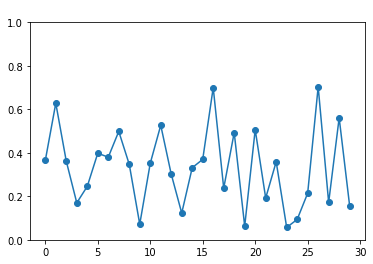

In [ ]:
visualise_correlations(correlations)